In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_log_error

In [311]:
df = pd.read_csv('train.csv')

In [312]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [313]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [314]:
del df['ID']

In [315]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):

    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities

def update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs'):

    race_group = sorted(df['race_group'].unique())
    survival_probs_dict = {}
    for race in race_group:
        race_df = df[df['race_group'] == race]
        survival_probs_dict[race] = transform_survival_probability(race_df, time_col, event_col)
    for race in race_group:
        df.loc[df['race_group'] == race, 'target'] = survival_probs_dict[race]
    df.loc[df[event_col] == 0, 'target'] -= 0.15
    
    return df

df = update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs')

In [316]:
#возможно временное, но нет смысла работать с данными
#где отстуствуют ключевые фичи
hla_columns = [x for x in df.columns if 'hla' in x]
df = df.drop(df.loc[df[hla_columns].isna().any(axis=1)].index).reset_index(drop=True)

In [317]:
#В данных присутствуют ошибки, лучше пересчитать кумалятивные фичи
#nmdp_6_restore
df['hla_nmdp_6'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
#hla_res_6_restore
df['hla_low_res_6'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) + df['hla_match_drb1_low'].fillna(0)
df['hla_high_res_6'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) + df['hla_match_drb1_high'].fillna(0)
#hla_res_8_restore
df['hla_low_res_8'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) \
+ df['hla_match_drb1_low'].fillna(0) + df['hla_match_c_low'].fillna(0)
df['hla_high_res_8'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) \
+ df['hla_match_drb1_high'].fillna(0) + df['hla_match_c_high'].fillna(0)
#hla_res_10_restore
df['hla_low_res_10'] = df['hla_match_a_low'].fillna(0) + df['hla_match_b_low'].fillna(0) \
+ df['hla_match_c_low'].fillna(0) + df['hla_match_dqb1_low'].fillna(0) + df['hla_match_drb1_low'].fillna(0)
df['hla_high_res_10'] = df['hla_match_a_high'].fillna(0) + df['hla_match_b_high'].fillna(0) \
+ df['hla_match_c_high'].fillna(0) + df['hla_match_dqb1_high'].fillna(0) + df['hla_match_drb1_high'].fillna(0)

In [318]:
df.shape

(21144, 60)

In [323]:
#новая фича
df.groupby(['dri_score', 'cyto_score', 'cyto_score_detail'], as_index=False)\
    .agg({'target':['mean', 'count']})\
    .sort_values(by=[('target', 'count'), ('target', 'mean')], ascending=[False, False])\
    .head(15)

dri_score    cyto_score  \
                                                               
60                                Intermediate  Intermediate   
24                                        High          Poor   
78                                Intermediate          Poor   
55                                Intermediate     Favorable   
6                                         High  Intermediate   
1                                         High     Favorable   
22                                        High          Poor   
187                            N/A - pediatric          Poor   
35   High - TED AML case <missing cytogenetics  Intermediate   
80                                Intermediate          Poor   
31   High - TED AML case <missing cytogenetics     Favorable   
215                           TBD cytogenetics          Poor   
171                            N/A - pediatric  Intermediate   
185                            N/A - pediatric          Poor   
83                                Intermediate           TBD   

    cyto_score_detail    target        
                           mean count  
60       Intermediate  0.522382  2774  
24               Poor  0.718597   870  
78       Intermediate  0.546533   857  
55       Intermediate  0.519203   818  
6        Intermediate  0.635013   491  
1        Intermediate  0.588970   389  
22       Intermediate  0.689136   379  
187              Poor  0.637150   345  
35       Intermediate  0.536062   322  
80               Poor  0.624881   280  
31       Intermediate  0.518165   179  
215              Poor  0.642565   158  
171      Intermediate  0.500851   153  
185      Intermediate  0.566192   152  
83       Intermediate  0.553698   148

In [248]:
df = df.drop(df[df.donor_age.isna()].index).reset_index(drop=True)

In [249]:
df['donor_age'] = df['donor_age'].astype('float')
df['age_at_hct'] = df['age_at_hct'].astype('float')
df['year_hct'] = df['year_hct'].astype('float')
df['pct_bd_age'] = (df['year_hct'] - df['age_at_hct']).astype('int')
df['donor_bd_age'] = (df['year_hct'] - df['donor_age']).astype('int')

In [254]:
df['pct_generation'] = pd.cut(
    df['age_at_hct'],
    bins=range(0, 101, 10),  # Интервалы с шагом 10 лет
    labels=[f"{i}-{i+9}" for i in range(0, 100, 10)],  # Названия поколений
    right=False  # Интервалы включают нижнюю границу, но исключают верхнюю
)

In [257]:
df['donor_generation'] = pd.cut(
    df['donor_age'],
    bins=range(0, 101, 10),  # Интервалы с шагом 10 лет
    labels=[f"{i}-{i+9}" for i in range(0, 100, 10)],  # Названия поколений
    right=False  # Интервалы включают нижнюю границу, но исключают верхнюю
)

# Нужно учитывать возможность появления новых категорий (к примеру возраст 80 лет)
# их нужно добавить в отдельную категорию unknow

# Потенциальная функция для восстановления категориальных фичей

In [ ]:
import pandas as pd

def fill_missing_with_mode(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    """
    Заполняет пропуски в указанной фиче (feature) модой, сгруппировав по 'generation_pct', 'sex', 'race'.

    Parameters:
    df (pd.DataFrame): Исходный DataFrame.
    feature (str): Название фичи, в которой нужно заполнить пропуски.

    Returns:
    pd.DataFrame: DataFrame с заполненными пропусками.
    """
    # Создаем копию DataFrame, чтобы не менять оригинал
    df_filled = df.copy()

    # Для каждой группы (generation_pct, sex, race) находим моду
    mode_values = df_filled.groupby(['generation_pct', 'sex', 'race'])[feature].agg(lambda x: x.mode()[0])

    # Функция для заполнения пропусков для каждой строки
    def fill_mode(row):
        if pd.isna(row[feature]):
            return mode_values.loc[(row['generation_pct'], row['sex'], row['race'])]
        return row[feature]

    # Применяем функцию к каждому ряду
    df_filled[feature] = df_filled.apply(fill_mode, axis=1)

    return df_filled

# Пример использования:

# Пример данных
data = pd.DataFrame({
    'generation_pct': [20, 20, 30, 30, 20, 30],
    'sex': ['M', 'F', 'M', 'F', 'M', 'F'],
    'race': ['White', 'White', 'Black', 'Black', 'White', 'Black'],
    'feature': [1, 2, None, 2, None, 3]
})

# Заполнение пропусков в колонке 'feature'
df_filled = fill_missing_with_mode(data, 'feature')

print(df_filled)

<Axes: xlabel='pct_generation', ylabel='Count'>

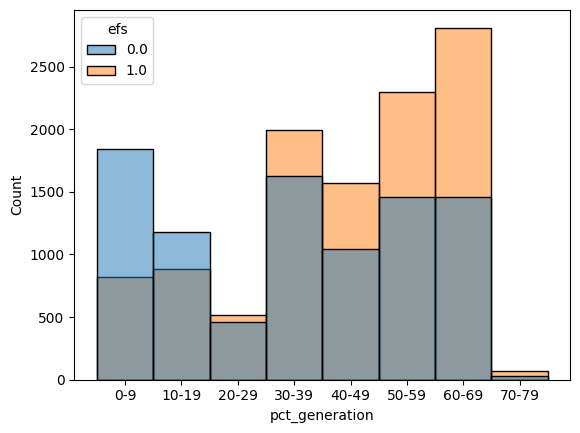

In [256]:
sns.histplot(data = df, x ='pct_generation', hue='efs')

<Axes: xlabel='donor_generation', ylabel='Count'>

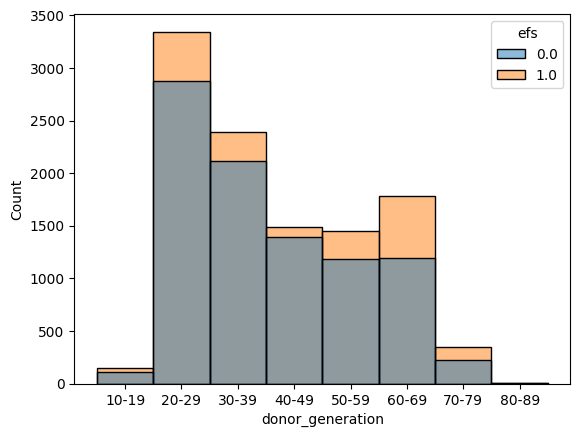

In [258]:
sns.histplot(data = df, x ='donor_generation', hue='efs')

In [259]:
df[['donor_sex', 'pacient_sex']] = df['sex_match'].str.split('-', expand=True)

In [260]:
df = df.assign(log_target=np.log(df['target'] + 1))

In [262]:
df = df.drop(columns=['efs', 'efs_time', 'target'])

In [263]:
df = df.round(3)

In [264]:
df.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,pct_bd_age,donor_bd_age,donor_sex,pacient_sex,pct_generation,donor_generation,log_target
0,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1964,1935,F,F,40-49,70-79,0.615
1,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009.0,No,Positive,No,Permissive,2.0,No,29.230,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1965,1979,M,M,40-49,20-29,0.201
2,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,6.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018.0,No,NaN,Yes,NaN,2.0,No,56.810,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,1988,1961,M,F,20-29,50-59,0.296
3,High,No,Poor,Yes,2.0,7.0,TBI + Cy +- Other,No,4.0,Peripheral blood,No,No,No,ALL,5.0,+/+,8.0,1.0,P/P,5.0,1.0,No,1.0,1.0,PB,TBD,MAC,Hispanic or Latino,2015.0,Yes,NaN,No,NaN,2.0,No,27.274,No,1.0,No,32.143,2.0,Cyclophosphamide alone,No,F-F,1.0,White,2.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",5.0,No,2.0,Yes,6.0,1982,1987,F,F,30-39,20-29,0.451
4,Low,No,Poor,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,-/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,RIC,Not Hispanic or Latino,2016.0,No,NaN,No,Permissive,2.0,No,45.016,No,2.0,No,17.673,2.0,FK+ MMF +- others,No,M-M,2.0,More than one race,1.0,90.0,No,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1998,1970,M,M,10-19,40-49,0.323


In [61]:
df.loc[0, ['hla_match_a_high', 'hla_match_b_high', 'hla_match_c_high', 'hla_match_drb1_high', 'hla_match_dqb1_high', 'efs']]

hla_match_a_high       2.0
hla_match_b_high       2.0
hla_match_c_high       2.0
hla_match_drb1_high    2.0
hla_match_dqb1_high    2.0
efs                    0.0
Name: 0, dtype: object

In [67]:
df.loc[5, ['hla_match_a_high', 'hla_match_b_high', 'hla_match_c_high', 'hla_match_drb1_high', 'hla_match_dqb1_high', 'efs']]

hla_match_a_high       2.0
hla_match_b_high       1.0
hla_match_c_high       2.0
hla_match_drb1_high    2.0
hla_match_dqb1_high    1.0
efs                    1.0
Name: 5, dtype: object

In [336]:

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import torch

torch.set_num_threads(8)

In [337]:
from sklearn.model_selection import train_test_split
numerical_features = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col not in ['ID', 'efs', 'efs_time', 'target']]


In [363]:
tr_data, te_data = train_test_split(df, test_size=0.25, random_state=42)

In [345]:
tr_data

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,target
7921,High,No,NaN,No,2.0,8.0,No TBI,NaN,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,NaN,MAC,Not Hispanic or Latino,2008,Yes,NaN,Yes,NaN,2.0,NaN,69.812,No,2.0,No,49.283,2.0,CSA + MMF +- others(not FK),No,F-M,2.0,More than one race,2.0,70.0,No,GvH non-permissive,Related,"N/A, Mel not given",8.0,No,2.0,NaN,10.0,1.0,1.582,0.995253
10215,N/A - pediatric,NaN,Poor,NaN,2.0,7.0,TBI + Cy +- Other,No,5.0,Peripheral blood,No,NaN,No,AML,5.0,+/+,9.0,2.0,P/P,5.0,2.0,NaN,2.0,2.0,PB,NaN,MAC,Not Hispanic or Latino,2018,No,NaN,No,NaN,1.0,NaN,30.725,No,2.0,NaN,27.688,1.0,Cyclophosphamide alone,NaN,F-M,2.0,American Indian or Alaska Native,0.0,90.0,NaN,Permissive mismatched,Related,"N/A, Mel not given",7.0,NaN,2.0,NaN,9.0,1.0,3.969,0.909603
13416,Intermediate,No,Intermediate,No,2.0,8.0,TBI + Cy +- Other,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,G/G,6.0,2.0,No,2.0,2.0,PB,Intermediate,NMA,Not Hispanic or Latino,2008,No,Negative,No,NaN,2.0,No,69.842,No,2.0,No,36.326,2.0,FK+ MTX +- others(not MMF),No,F-F,2.0,More than one race,1.0,90.0,No,GvH non-permissive,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,129.111,0.380674
14377,Low,No,Poor,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,IPA,6.0,-/-,10.0,2.0,NaN,6.0,2.0,NaN,2.0,2.0,PB,Intermediate,RIC,Not Hispanic or Latino,2012,No,Negative,Yes,NaN,2.0,No,53.183,Not done,2.0,No,63.050,2.0,FKalone,No,M-M,2.0,Black or African-American,2.0,80.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,1.0,8.310,0.508389
17644,Intermediate,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/-,10.0,2.0,H/H,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2016,No,Negative,No,HvG non-permissive,2.0,No,NaN,No,2.0,No,8.991,2.0,FK+ MMF +- others,No,M-F,2.0,Black or African-American,0.0,90.0,No,HvG non-permissive,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,47.347,0.289634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,N/A - pediatric,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,SAA,6.0,-/-,10.0,2.0,H/B,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2014,No,NaN,No,GvH non-permissive,2.0,No,50.233,No,2.0,No,0.208,2.0,CSA + MMF +- others(not FK),No,F-F,2.0,More than one race,2.0,100.0,No,Bi-directional non-permissive,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,67.154,0.380674
11964,High,Yes,Poor,Yes,2.0,5.0,TBI + Cy +- Other,No,4.0,Bone marrow,No,No,No,ALL,3.0,+/-,7.0,2.0,P/P,4.0,2.0,No,1.0,1.0,BM,NaN,MAC,Not Hispanic or Latino,2016,No,Positive,No,Permissive,1.0,No,37.274,No,2.0,No,62.582,1.0,Cyclophosphamide alone,No,M-F,1.0,American Indian or Alaska Native,5.0,70.0,No,Permissive mismatched,Unrelated,"N/A, Mel not given",6.0,No,1.0,Yes,7.0,1.0,5.240,0.799555
5390,N/A - pediatric,No,Poor,No,1.0,4.0,TBI + Cy +- Other,No,3.0,Bone marrow,No,No,No,ALL,3.0,+/+,5.0,1.0,P/P,3.0,1.0,No,1.0,1.0,BM,Intermediate,MAC,Not Hispanic or Latino,2018,No,NaN,No,NaN,1.0,No,71.208,No,1.0,No,14.503,1.0,Cyclophosphamide alone,No,M-F,1.0,Black or African-Am

In [346]:
task = Task('reg', loss='mse', metric='mse')

In [347]:

roles = {
    'target' : 'target'
}

In [348]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Дополнительно: если числовые признаки имеют низкую кардинальность
low_cardinality_features = [
    col for col in df.select_dtypes(include=['int64', 'float64']).columns if df[col].nunique() <= 10
    and 'hla_' not in col
]

# Итоговые категориальные фичи
categorical_features += low_cardinality_features

In [354]:
automl = TabularAutoML(task=task,
                      timeout=300,
                      cpu_limit=8,
                      reader_params={
                          'use_algos': ['lgb', 'cb'],
                          'force_input_features': categorical_features,
                          'n_jobs' : 8,
                          'cv' : 5,
                          'random_state': 13,
                          'verbose' : 1
                      })

In [355]:
oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)

[02:40:52] Stdout logging level is INFO.
[02:40:52] Task: reg

[02:40:52] Start automl preset with listed constraints:
[02:40:52] - time: 300.00 seconds
[02:40:52] - CPU: 8 cores
[02:40:52] - memory: 16 GB

[02:40:52] Train data shape: (15858, 60)

[02:40:52] Layer 1 train process start. Time left 299.53 secs
[02:40:52] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[02:40:54] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.012600897298221482
[02:40:54] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[02:40:54] Time left 297.67 secs

[02:40:55] Selector_LightGBM fitting and predicting completed
[02:40:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[02:40:58] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.001514109900100586
[02:40:58] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[02:40:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 88.77 secs


Optimization Progress: 100%|█████████████████████| 101/101 [01:12<00:00,  1.40it/s, best_trial=91, best_value=-0.00155]

[02:42:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[02:42:10] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[02:42:11] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.001514572619437823
[02:42:11] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[02:42:11] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[02:42:23] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.0015515051141531343
[02:42:23] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[02:42:23] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 82.42 secs


Optimization Progress:  28%|██████                | 28/101 [01:24<03:41,  3.03s/it, best_trial=15, best_value=-0.00159]

[02:43:48] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[02:43:48] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[02:44:00] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.0015481151043812023
[02:44:00] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[02:44:00] Time left 111.40 secs

[02:44:00] Layer 1 training completed.

[02:44:00] Blending: optimization starts with equal weights. Score = -0.0019250
[02:44:00] Blending: iteration 0: score = -0.0015029, weights = [0.        0.4245582 0.315978  0.1297319 0.1297319]
[02:44:00] Blending: iteration 1: score = -0.0015028, weights = [0.         0.38715887 0.34453982 0.11647159 0.15182972]
[02:44:00] Blending: no improvements for score. Terminated.

[02:44:00] Blending: best score = -0.0015028, best weights = [0.         0.38715887 0.34453982 0.11647159 0.15182972]
[02:44:00] Automl preset training completed in 188.67 seconds

[02:44:00] Model description:
Final prediction for new objects (level 0) = 
	 0.38716 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.34454 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_L

In [351]:
#oof_pred_exp = np.exp(oof_pred.data[:, 0]) - 1

In [352]:
#target = np.exp(tr_data['log_target'].values) - 1

KeyError: 'log_target'

In [356]:
sum(np.round(oof_pred_exp, 1)==np.round(tr_data['target'], 1))

7

In [360]:
oof_pred

array([[0.98785377],
       [0.9075221 ],
       [0.30139935],
       ...,
       [0.319269  ],
       [0.6557455 ],
       [0.6862404 ]], dtype=float32)

In [361]:
tr_data['target']

7921     0.995253
10215    0.909603
13416    0.380674
14377    0.508389
17644    0.289634
           ...   
11284    0.380674
11964    0.799555
5390     0.291996
860      0.640236
15795    0.675589
Name: target, Length: 15858, dtype: float64

In [364]:
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(te_data['target'], automl.predict(te_data)))

AssertionError: Numpy dataset support only np.ndarray features

In [365]:
automl.predict(te_data)

array([[0.7019297 ],
       [0.57705754],
       [0.9002573 ],
       ...,
       [0.97021806],
       [0.33924496],
       [0.79741573]], dtype=float32)

In [366]:
te_data['target']

640      0.698406
9864     0.526119
9861     0.898956
16883    0.793626
21058    0.291274
           ...   
20207    0.638516
6824     0.842318
4352     0.968215
16716    0.341160
9681     0.787828
Name: target, Length: 5286, dtype: float64